In [2]:
import sys
sys.path.append('../03_transformer_tutorial_1st_part/BERT_tutorial_and_attention_visualization')

import torch
from models.bert_model import BertModel, BertConfig
from dataset.inference_dataloader import preprocessing
import warnings
import json
import math
import os
import configparser
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

Matplotlib is building the font cache; this may take a moment.


In [55]:
font = FontProperties(fname='../03_transformer_tutorial_1st_part/BERT_tutorial_and_attention_visualization/SimHei.ttf')

In [20]:
pad_index = 0
unk_index = 1
cls_index = 2
sep_index = 3
mask_index = 4
num_index = 5

config={}
config["train_corpus_path"] = "./wiki_train.txt"
config["test_corpus_path"] = "./wiki_test.txt"
config["word2idx_path"] = "./my_bert_word2idx.json"
config["output_path"] = "./output_wiki_bert"
config["state_dict_dir"] = "../03_transformer_tutorial_1st_part/BERT_tutorial_and_attention_visualization/bert_state_dict"

config["batch_size"] = 1
config["max_seq_len"] = 200
config["vocab_size"] = 32162
config["lr"] = 2e-6
config["num_workers"] = 0

In [21]:
vocab_size = int(config["vocab_size"])
print("vocab_size", vocab_size)
batch_size=1
cuda_condition = torch.cuda.is_available()
print("cuda_condition", cuda_condition)
device = torch.device("cuda:0" if cuda_condition else "cpu")
print("device", device)
max_seq_len = 256



vocab_size 32162
cuda_condition False
device cpu


In [22]:
word2idx={}
with open(config["word2idx_path"], "r", encoding="utf-8") as f:
    word2idx = json.load(f)

word2idx

{'#PAD#': 0,
 '#UNK#': 1,
 '#SEP#': 3,
 '#CLS#': 2,
 '#MASK#': 4,
 '#NUM#': 5,
 '计': 20,
 '算': 21,
 '机': 22,
 '科': 23,
 '学': 24,
 '\n': 25,
 '（': 26,
 '，': 27,
 '有': 28,
 '时': 29,
 '缩': 30,
 '写': 31,
 '为': 32,
 '）': 33,
 '是': 34,
 '系': 35,
 '统': 36,
 '性': 37,
 '研': 38,
 '究': 39,
 '信': 40,
 '息': 41,
 '与': 42,
 '的': 43,
 '理': 44,
 '论': 45,
 '基': 46,
 '础': 47,
 '以': 48,
 '及': 49,
 '它': 50,
 '们': 51,
 '在': 52,
 '中': 53,
 '如': 54,
 '何': 55,
 '应': 56,
 '用': 57,
 '实': 58,
 '技': 59,
 '术': 60,
 '。': 61,
 ' ': 62,
 '通': 63,
 '常': 64,
 '被': 65,
 '形': 66,
 '容': 67,
 '对': 68,
 '那': 69,
 '些': 70,
 '创': 71,
 '造': 72,
 '、': 73,
 '描': 74,
 '述': 75,
 '转': 76,
 '换': 77,
 '法': 78,
 '处': 79,
 '包': 80,
 '含': 81,
 '很': 82,
 '多': 83,
 '分': 84,
 '支': 85,
 '领': 86,
 '域': 87,
 '；': 88,
 '强': 89,
 '调': 90,
 '特': 91,
 '定': 92,
 '结': 93,
 '果': 94,
 '比': 95,
 '图': 96,
 '而': 97,
 '探': 98,
 '讨': 99,
 '问': 100,
 '题': 101,
 '质': 102,
 '复': 103,
 '杂': 104,
 '还': 105,
 '一': 106,
 '专': 107,
 '注': 108,
 '于': 109,
 '怎': 110,

In [49]:
bertconfig = BertConfig(vocab_size_or_config_json_file=vocab_size)
#bertconfig.num_attention_heads=1
bert_model = BertModel(config=bertconfig)
bert_model.to(device)
print("bertconfig", bertconfig)

bertconfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "max_position_embeddings": 1024,
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "type_vocab_size": 256,
  "vocab_size": 32162
}



In [24]:
process_batch = preprocessing(hidden_dim=bertconfig.hidden_size, max_positions=max_seq_len,word2idx=word2idx)

In [25]:
#load_model(self.bert_model, dir_path=self.config["state_dict_dir"])

def find_most_recent_state_dict(dir_path):
    # 找到模型存储的最新的state_dict路径
    dic_lis = [i for i in os.listdir(dir_path)]
    if len(dic_lis) == 0:
        raise FileNotFoundError("can not find any state dict in {}!".format(dir_path))
    dic_lis = [i for i in dic_lis if "model" in i]
    dic_lis = sorted(dic_lis, key=lambda k: int(k.split(".")[-1]))
    return dir_path + "/" + dic_lis[-1]

model = bert_model
dir_path=config["state_dict_dir"]
# 加载模型
checkpoint_dir = find_most_recent_state_dict(dir_path)
print("checkpoint_dir", checkpoint_dir)
checkpoint = torch.load(checkpoint_dir)
print("checkpoint[\"model_state_dict\"].items()", [k[5:] for k, v in checkpoint["model_state_dict"].items() if k[:4] == "bert"])
# 不加载masked language model 和 next sentence 的参数
checkpoint["model_state_dict"] = {k[5:]: v for k, v in checkpoint["model_state_dict"].items() if k[:4] == "bert"}
model.load_state_dict(checkpoint["model_state_dict"], strict=True)
torch.cuda.empty_cache()
model.to(device)
print("{} loaded for evaluation!".format(checkpoint_dir))

checkpoint_dir ../03_transformer_tutorial_1st_part/BERT_tutorial_and_attention_visualization/bert_state_dict/bert.model.epoch.3
checkpoint["model_state_dict"].items() ['embeddings.word_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.laye

In [26]:
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32162, 384, padding_idx=0)
    (token_type_embeddings): Embedding(256, 384)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=384, out_features=1536,

In [28]:
text_list='历史上的今天发生了什么事？'
print(text_list)
# 异常判断
if isinstance(text_list, str):
    text_list = [text_list, ]
len_ = len(text_list)
text_list = [i for i in text_list if len(i) != 0]
if len(text_list) == 0:
    raise NotImplementedError("输入的文本全部为空, 长度为0!")
if len(text_list) < len_:
    warnings.warn("输入的文本中有长度为0的句子, 它们将被忽略掉!")

# max_seq_len=self.max_seq_len+2 因为要留出cls和sep的位置
max_seq_len = max([len(i) for i in text_list])
print(max_seq_len, text_list)

texts_tokens, positional_enc = process_batch(text_list, max_seq_len=max_seq_len)

print(texts_tokens, positional_enc)

历史上的今天发生了什么事？
13 ['历史上的今天发生了什么事？']
tensor([[  2, 485, 486, 149,  43, 321, 302, 258, 660, 265, 529, 530, 138, 533,
           3]]) tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.0670e-02,  4.1754e-02,  5.6858e-02,  ...,  7.2100e-02,
          7.9360e-10,  7.2100e-02],
        [ 6.5555e-02, -2.3738e-02,  6.9920e-02,  ...,  7.2095e-02,
          1.5871e-09,  7.2095e-02],
        ...,
        [-3.8724e-02,  3.0894e-02, -7.1855e-02,  ...,  7.2170e-02,
          9.5324e-09,  7.2170e-02],
        [ 3.0305e-02,  7.1022e-02, -4.9462e-02,  ...,  7.2127e-02,
          1.0321e-08,  7.2127e-02],
        [ 7.1389e-02,  5.1339e-02,  1.0974e-02,  ...,  7.2066e-02,
          1.1105e-08,  7.2066e-02]])


In [29]:
positional_enc.shape

torch.Size([15, 384])

In [30]:
positional_enc = torch.unsqueeze(positional_enc, dim=0).to(device)
positional_enc

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 6.0670e-02,  4.1754e-02,  5.6858e-02,  ...,  7.2100e-02,
           7.9360e-10,  7.2100e-02],
         [ 6.5555e-02, -2.3738e-02,  6.9920e-02,  ...,  7.2095e-02,
           1.5871e-09,  7.2095e-02],
         ...,
         [-3.8724e-02,  3.0894e-02, -7.1855e-02,  ...,  7.2170e-02,
           9.5324e-09,  7.2170e-02],
         [ 3.0305e-02,  7.1022e-02, -4.9462e-02,  ...,  7.2127e-02,
           1.0321e-08,  7.2127e-02],
         [ 7.1389e-02,  5.1339e-02,  1.0974e-02,  ...,  7.2066e-02,
           1.1105e-08,  7.2066e-02]]])

In [31]:
n_batches = math.ceil(len(texts_tokens) / batch_size)
n_batches

1

In [50]:
#for i in range(n_batches):
i = 0
start = i * batch_size
end = start + batch_size
# 切片
texts_tokens_ = texts_tokens[start: end].to(device)
print("texts_tokens_", texts_tokens_)
attention_matrices = bert_model.forward(input_ids=texts_tokens_,
                                                positional_enc=positional_enc,
                                                get_attention_matrices=True)
for i in attention_matrices:
    print("i", i.shape)
# 因为batch size=1所以直接返回每层的注意力矩阵
attention_matrices = [i.detach().numpy() for i in attention_matrices]
for i in attention_matrices:
    print(i.shape)

texts_tokens_ tensor([[  2, 485, 486, 149,  43, 321, 302, 258, 660, 265, 529, 530, 138, 533,
           3]])
i torch.Size([1, 12, 15, 15])
i torch.Size([1, 12, 15, 15])
i torch.Size([1, 12, 15, 15])
i torch.Size([1, 12, 15, 15])
i torch.Size([1, 12, 15, 15])
i torch.Size([1, 12, 15, 15])
(1, 12, 15, 15)
(1, 12, 15, 15)
(1, 12, 15, 15)
(1, 12, 15, 15)
(1, 12, 15, 15)
(1, 12, 15, 15)


(15, 15)
['#CLS# ', '历', '史', '上', '的', '今', '天', '发', '生', '了', '什', '么', '事', '？', '#SEP# ']


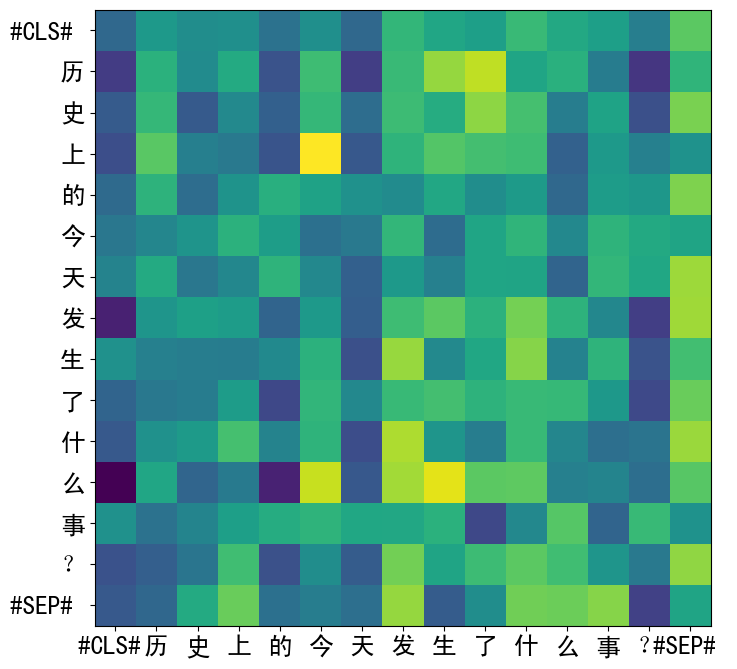

In [60]:
#def plot_attention(self, text, attention_matrices, layer_num, head_num):
text = "历史上的今天发生了什么事？"
#attention_matrices = 
layer_num = 2
head_num = 1

print(attention_matrices[layer_num][0][head_num].shape)

labels = [i for i in list(text)]
labels = ["#CLS# ", ] + labels + ["#SEP# ", ]
print(labels)
plt.figure(figsize=(8, 8))
plt.imshow(attention_matrices[layer_num][0][head_num])
plt.yticks(range(len(labels)), labels, fontproperties=font, fontsize=18)
plt.xticks(range(len(labels)), labels, fontproperties=font, fontsize=18)
plt.show()